1. containers are working     +
2. rewrite code in notebooks to work with db    +
4. class in fastapi to work with data  
3. analysis of data in bitcoin and bike   
5. frontend

#### Today
1. All images and data of data analysis in jupyter (not ml)

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot

import numpy as np
import subprocess
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os

from sqlalchemy import create_engine, text
import redis, json
from io import StringIO, BytesIO
from dotenv import load_dotenv

from scalecast.Forecaster import Forecaster
from scalecast import GridGenerator
from scalecast.util import plot_reduction_errors
from scalecast.SeriesTransformer import SeriesTransformer
from scalecast.auxmodels import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

In [2]:
load_dotenv()
def get_environ():
    return {"user": os.getenv("DB_USER"),
            "password": os.getenv("DB_PASSWORD"),
            "host": 'localhost',
            "port": os.getenv("DB_PORT"),
            "database": os.getenv("DB_NAME"),
            "redis_user": os.getenv("REDIS_USER"),
            "redis_password": os.getenv("REDIS_PASSWORD"),
            "redis_host": 'localhost',
            "redis_port": os.getenv("REDIS_PORT")
           }

def redis_cache_df(func):
    def wrapper(df_name):
        res = r.get(df_name)
        if res is None: 
            res = func(df_name)
            csv_buffer = StringIO()
            res.to_csv(csv_buffer, index=True)
            df_string = csv_buffer.getvalue()
            r.set(df_name, df_string)
        else:
            res = pd.read_csv(StringIO(res.decode('utf-8')))
        return res
    return wrapper

def get_engine():
    EV = get_environ()
    return create_engine(f"postgresql+psycopg2://{EV['user']}:{EV['password']}@{EV['host']}:{EV['port']}/{EV['database']}")

def get_redis():
    EV = get_environ()
    return redis.from_url(f"redis://{EV['redis_user']}:{EV['redis_password']}@{EV['redis_host']}:{EV['redis_port']}/0")
    # return redis.from_url(f"redis://{EV['redis_user']}:{EV['redis_password']}@{EV['redis_host']}:{EV['redis_port']}/0")

@redis_cache_df
def get_data(d_name):
    query = text(f'select * from {d_name}')
    res = pd.read_sql_query(query, get_engine())
    return res

To prevent redis warning **"Memory overcommit must be enabled"**:

```vm.overcommit_memory = 1```

to /etc/sysctl.conf

In [3]:
# redis testing
r = get_redis()
# r
try:
    info = r.info()
    print(info['redis_version'])
    response = r.ping()
    if response:
        print("Подключение успешно!")
    else:
        print("Не удалось подключиться к Redis.")
except redis.exceptions.RedisError as e:
    print(f"Ошибка: {e}")

8.0.3
Подключение успешно!


In [2]:
GridGenerator.get_grids()

In [4]:
data = (
    get_data('co2')
    .rename({"date": "month"}, axis=1)
    .set_index('month')
    .sort_index()
)
# data.head()

In [5]:
f = Forecaster(
    y = data['co2'],
    current_dates=data.index,
    future_dates=12,
    test_length=24,
    # metrics = ['rmse','mae','mape','r2'],
    cis=True
)

# Plot data

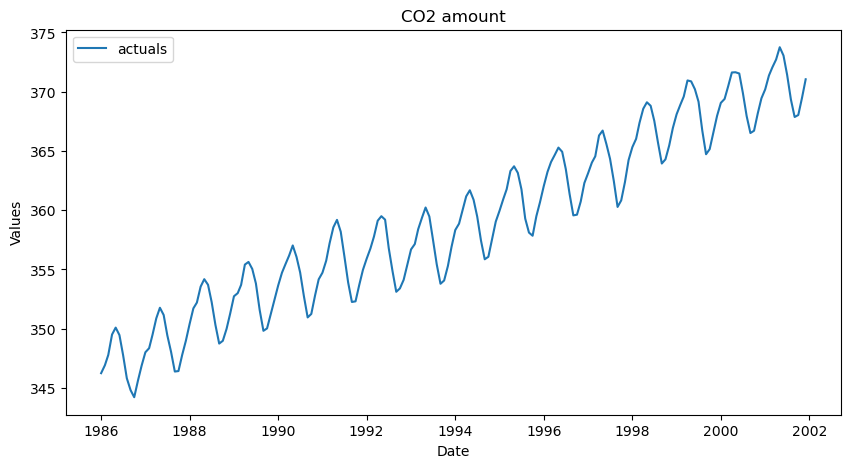

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title("CO2 amount")
f.plot(ax=ax);

# Show seasonality, trand and residuals

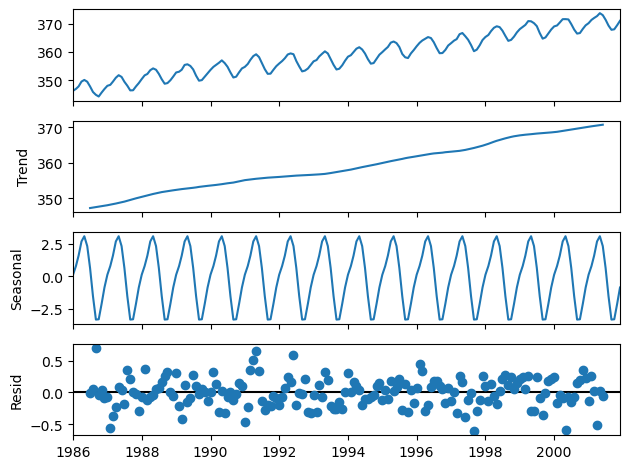

In [6]:
f.seasonal_decompose().plot();

# Test for seasonality. Deseasonalize a Time Series

In [23]:
data.query('co2 <= 0').count().values[0]

0

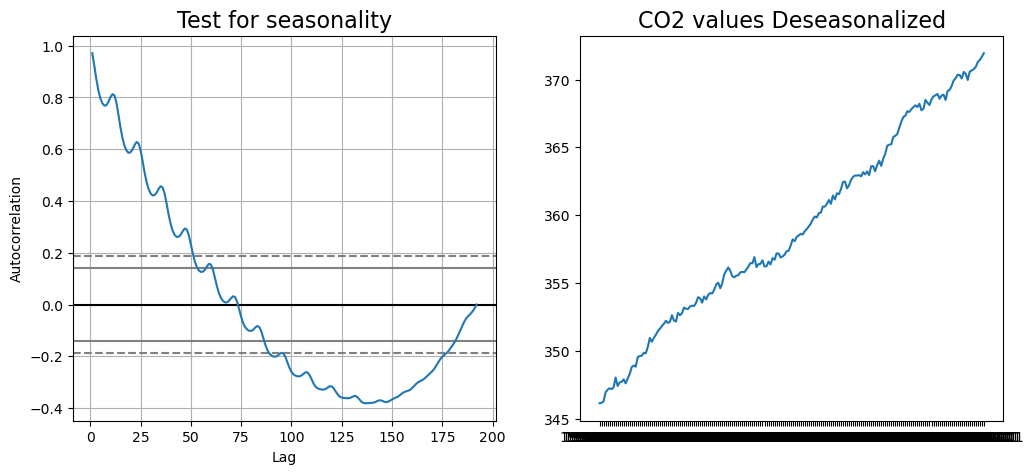

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.set_title("Test for seasonality", fontsize=16)
autocorrelation_plot(data['co2'].tolist(), ax=ax1)

additive_decomposition = seasonal_decompose(data['co2'], model="multiplicative", period=12)
deseasonalized = data['co2'].values / additive_decomposition.seasonal

ax2.plot(deseasonalized)
ax2.set_title('CO2 values Deseasonalized', fontsize=16);

# Distribution of co2 amount for months

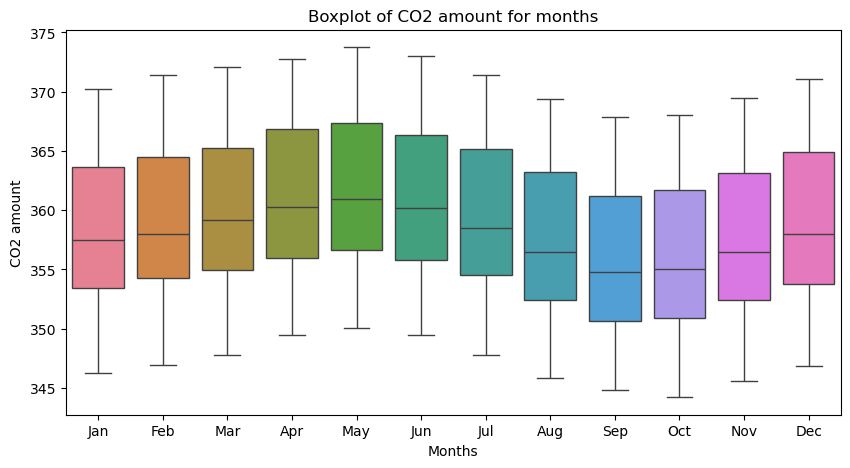

In [7]:
data_with_month_number = data.reset_index().assign(month_name = lambda x: x['month'].astype("datetime64[ns]").dt.strftime("%b"))
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlabel("Months")
ax.set_ylabel("CO2 amount")
ax.set_title("Boxplot of CO2 amount for months")
sns.boxplot(data=data_with_month_number[["month_name", "co2"]], x='month_name', y ="co2", ax=ax, hue='month_name')
plt.show;

# ACF PACF plots

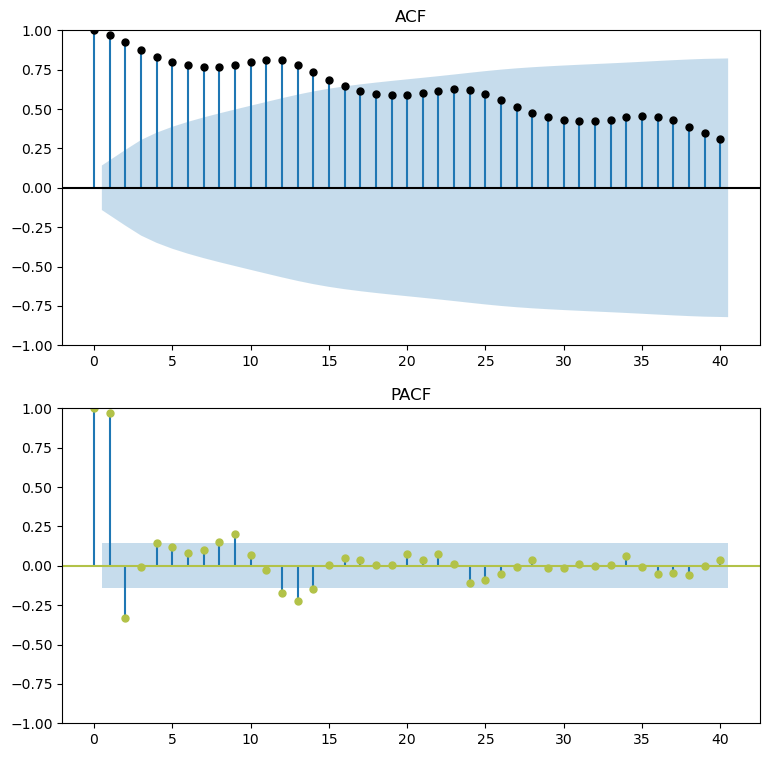

In [9]:
figs, (ax1, ax2) = plt.subplots(2, 1,figsize=(9,9))
f.plot_acf(ax=ax1, title='ACF', lags=40, color='black')
f.plot_pacf(ax=ax2, title='PACF', lags=40, color='#B2C248', method='ywm')
plt.show();

# Lag plots

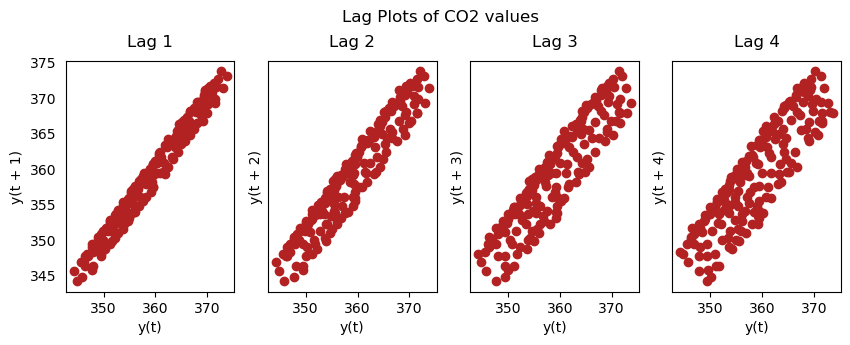

In [10]:
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(data['co2'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of CO2 values', y=1.05)    
plt.show()

# Stationarity. Augmented Dickey Fuller test (ADF Test)

In [11]:
adf, pval, usedlag, nobs, crit_vals, icbest = f.adf_test(full_res=True)
print('ADF test statistic: ', adf)
print('ADF p-value: ', pval)
print('Number of lags used: ', usedlag)
print('Number of observations: ', nobs)
print('Critical values: ', crit_vals)
print('Best information criterion: ', icbest)

ADF test statistic:  -0.3504228561776356
ADF p-value:  0.9180531321225159
Number of lags used:  13
Number of observations:  178
Critical values:  {'1%': -3.467631519151906, '5%': -2.8779183721695567, '10%': -2.575501353364474}
Best information criterion:  115.2031790046538


# Detrend a Time Series

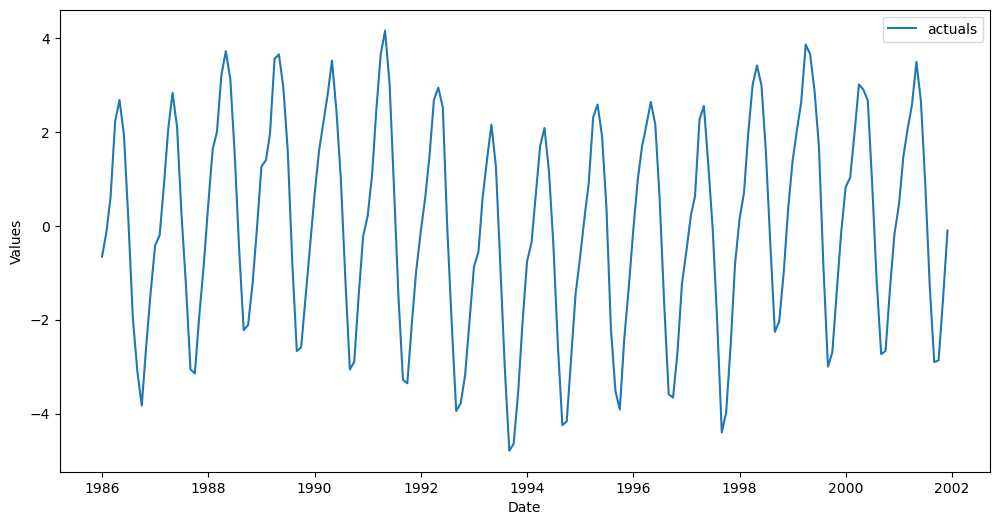

In [7]:
transformer = SeriesTransformer(f)
f_detrended = transformer.DetrendTransform(m=12)
f_detrended.plot();

#### Subtraction the trend component obtained from time series decomposition

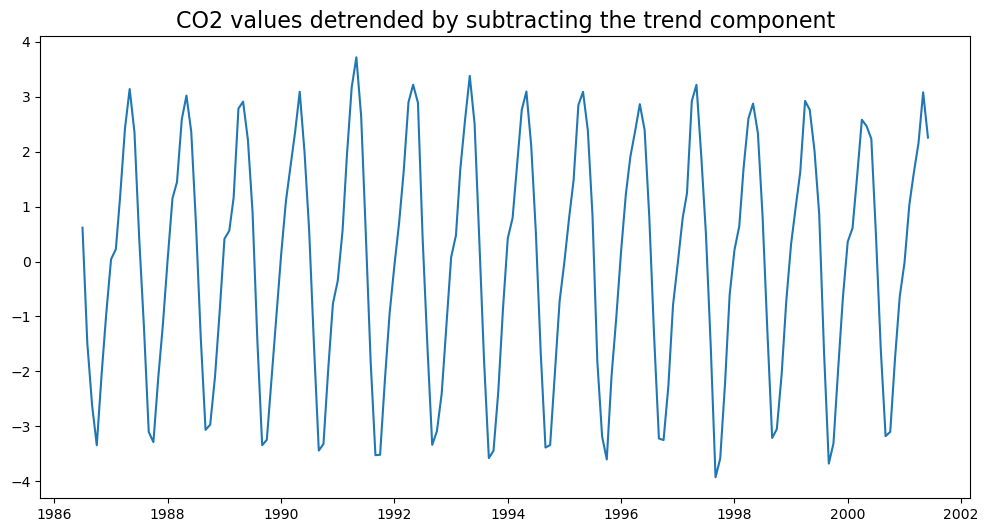

In [60]:
from PIL import Image
import cv2

additive_decomposition = seasonal_decompose(data['co2'], model="additive", period=12)
detrended = (data["co2"].values - f.seasonal_decompose().trend)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(detrended)
ax.set_title('CO2 values detrended by subtracting the trend component', fontsize=16)
plt.show()

# Parametrize the forecaster object

In [32]:
f.add_time_trend()
f.add_seasonal_regressors('year', raw=False, sincos=True)
f.auto_Xvar_select(cross_validate=True) # find best look-back, trend, and seasonality for your series

# Tell the Object to Evaluate Confidence Intervals
f.eval_cis(mode = True, cilevel = .95)

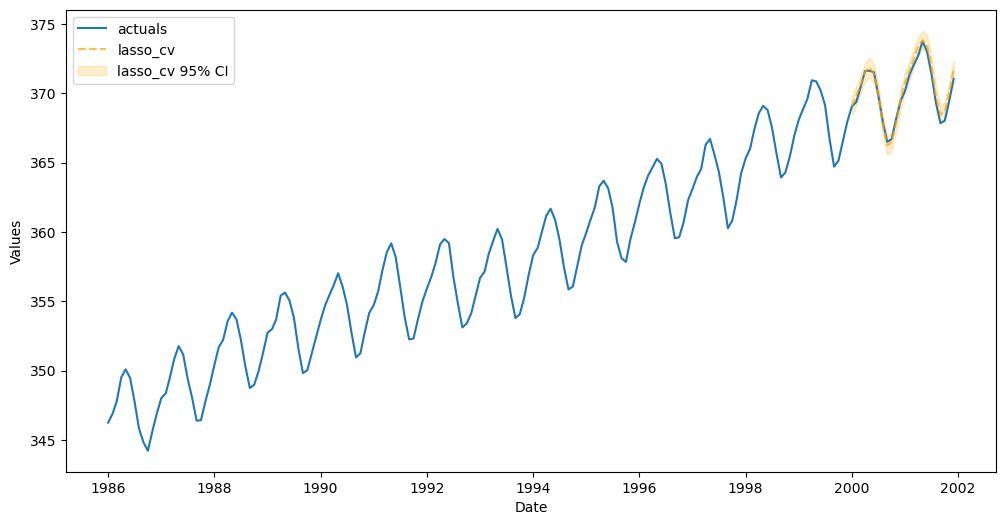

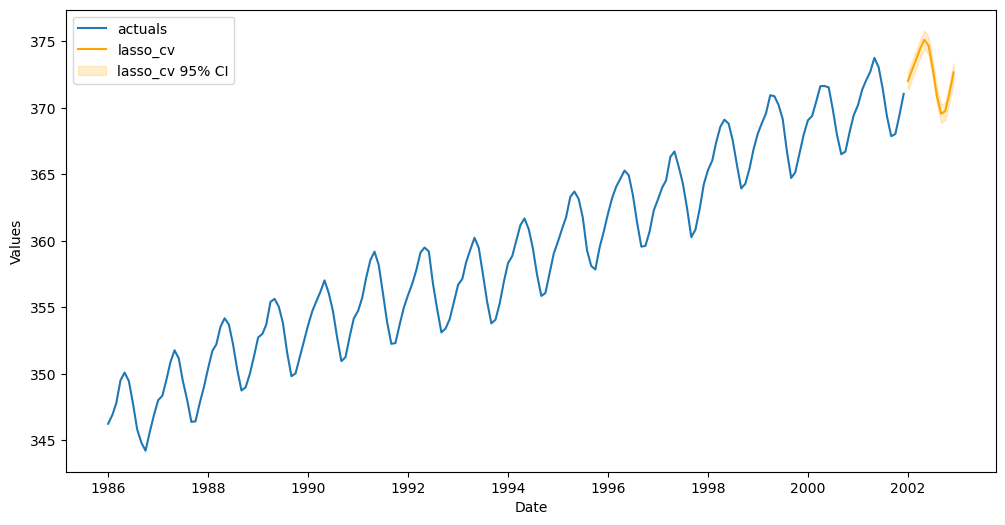

In [34]:
f.set_estimator('lasso')
lasso_grid = {'alpha':np.linspace(0,2,100)}
f.ingest_grid(lasso_grid)
f.cross_validate(k=3)
f.auto_forecast(call_me="lasso_cv")

f.plot_test_set(ci=True, models='lasso_cv')
f.plot(models='lasso_cv', ci=True)
plt.show()

# Linear Scikit-Learn Models

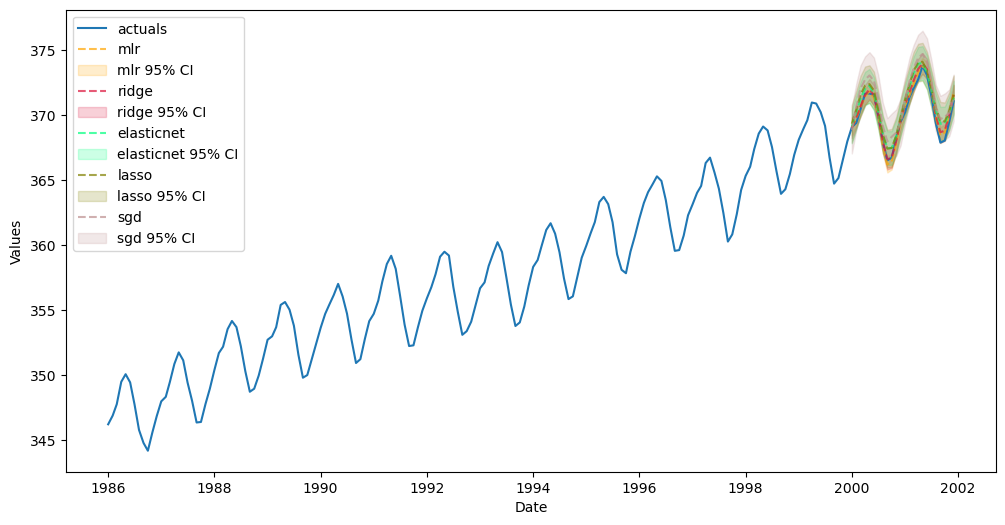

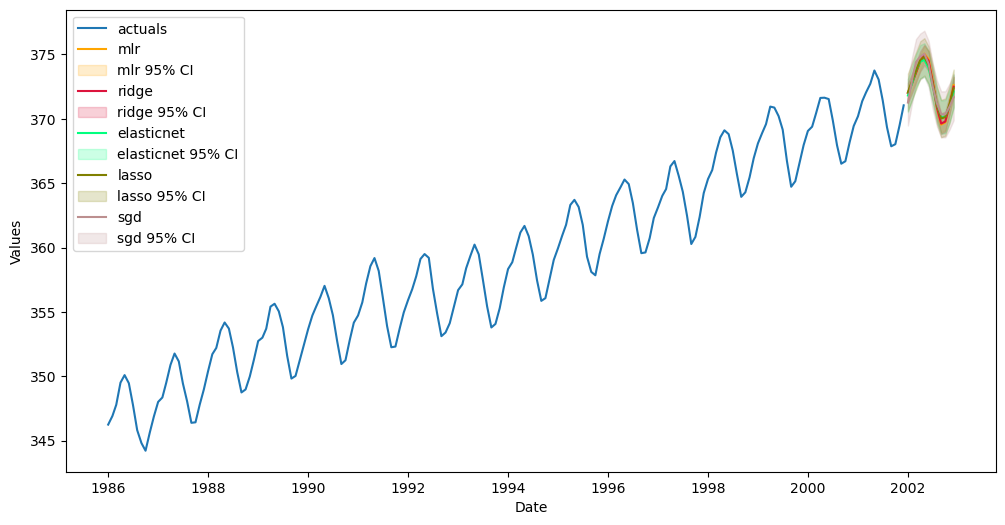

In [25]:
linear_sklearn_models=['mlr', 'lasso','ridge','elasticnet','sgd']

for model in linear_sklearn_models:
    f.set_estimator(model)
    f.cross_validate(k=5) # tune model hyperparams using time series cross validation
    f.auto_forecast() # automatically forecast with the chosen Xvars and hyperparams

f.plot_test_set(ci=True, models=linear_sklearn_models ,order_by='TestSetRMSE');
f.plot(ci=True,models=linear_sklearn_models,order_by='TestSetRMSE')
plt.show();

# Non-linear Scikit-Learn Models

In [104]:
f.set_estimator('xgboost')
xgboost_grid = {
     'n_estimators':[150,200,250, 500],
     'scale_pos_weight':[5,10],
     'learning_rate':[0.1,0.2, 0.5],
     'gamma':[0,3,5],
     'subsample':[0.8,0.9]
}
f.ingest_grid(xgboost_grid)
f.auto_Xvar_select(cross_validate=True, estimator='xgboost', trend_estimator='xgboost')
f.cross_validate(k=5)
f.auto_forecast()

<AxesSubplot: xlabel='Date', ylabel='Values'>

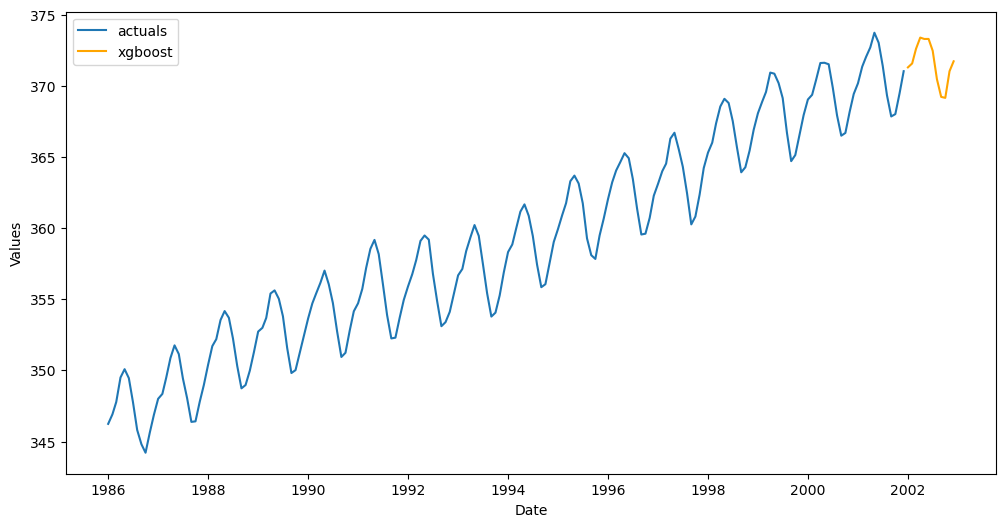

In [106]:
# f.plot_test_set(ci=True, models=['xgboost'])
f.plot(models = ['xgboost'])

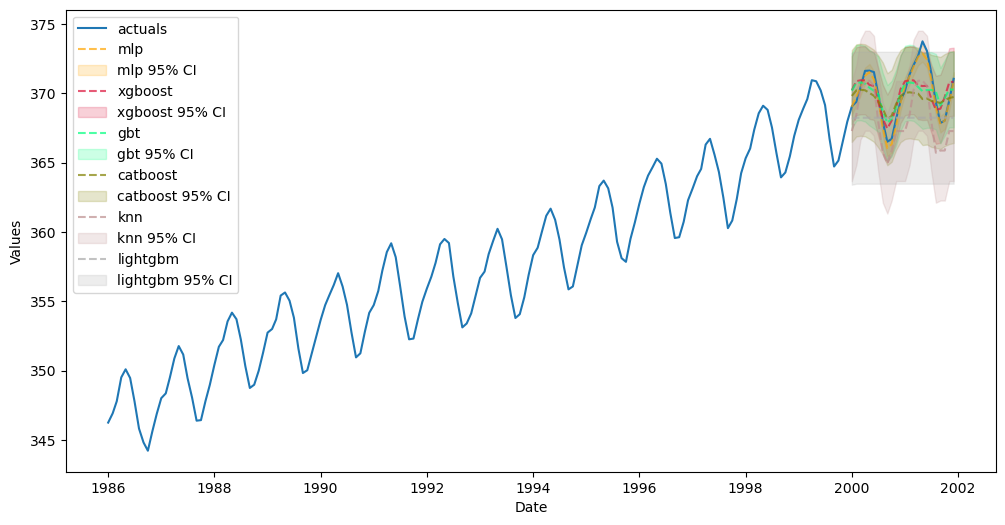

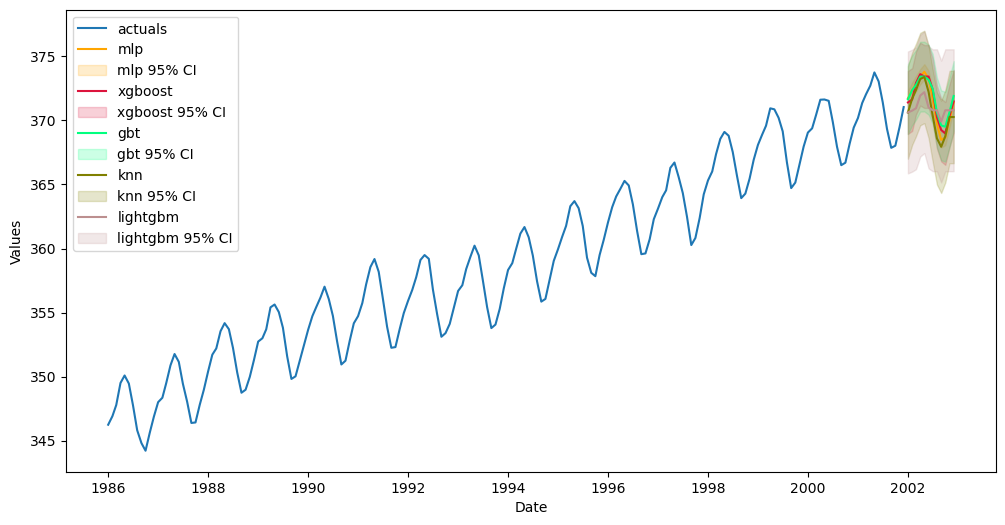

In [27]:
non_linear_sklearn_models = ['gbt','xgboost','lightgbm','catboost','knn', 'mlp']

for model in non_linear_sklearn_models:
    f.set_estimator(model)
    f.cross_validate(k=5) # tune model hyperparams using time series cross validation
    f.auto_forecast() # automatically forecast with the chosen Xvars and hyperparams

f.plot_test_set(ci=True, models=['gbt','xgboost','lightgbm','catboost','knn', 'mlp'], order_by='TestSetRMSE')
f.plot(ci=True,models=['rf','gbt','xgboost','lightgbm','knn','mlp'],order_by='TestSetRMSE')
plt.show()

# Arima

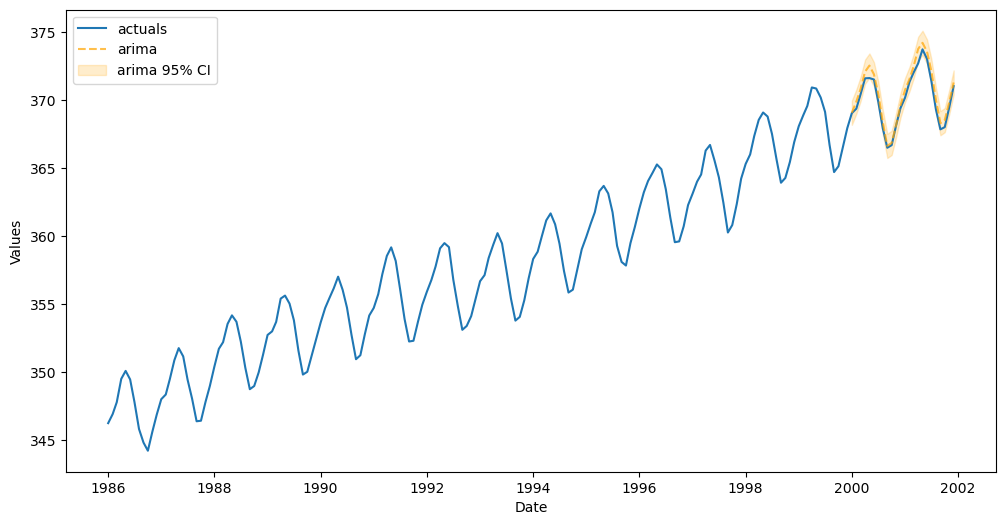

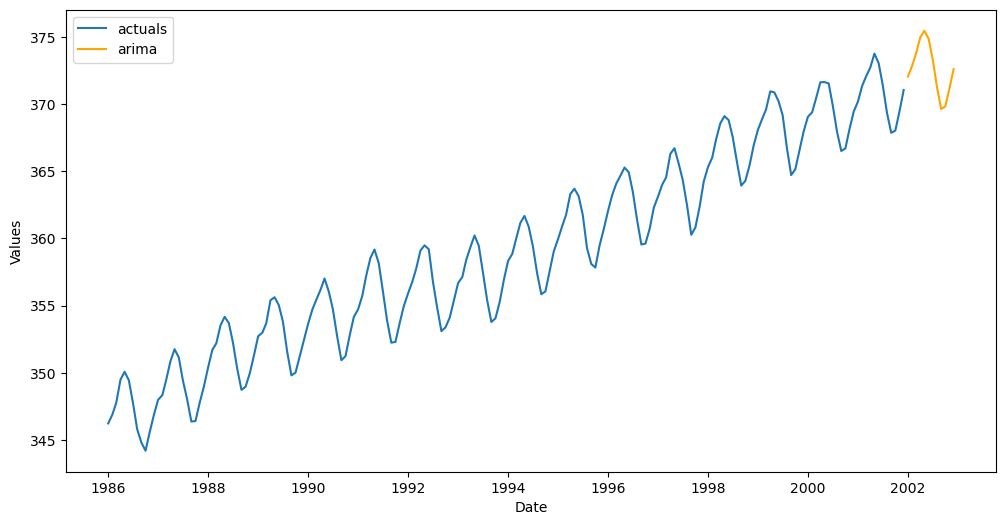

In [33]:
f.set_estimator('arima') # select an estimator
f.cross_validate(k=3) # tune model hyperparams using time series cross validation
f.auto_forecast() # automatically forecast with the chosen Xvars and hyperparams

results = f.export(['lvl_fcsts','model_summaries']) # extract results
f.plot_test_set(ci=True, models=['arima'])
f.plot(models=['arima']);

# LSTM

In [ ]:
f.set_estimator('lstm')
f.cross_validate(k=3) # tune model hyperparams using time series cross validation
f.auto_forecast() # automatically forecast with the chosen Xvars and hyperparams
# f.manual_forecast() # above args are now available in this function

In [36]:
f.tf_model.summary() # view a summary of the model's parameters

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_63 (LSTM)                  │ (None, 25, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_64 (LSTM)                  │ (None, 25, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_65 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,238 (602.50 KB)

 Trainable params: 51,412 (200.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 102,826 (401.67 KB)

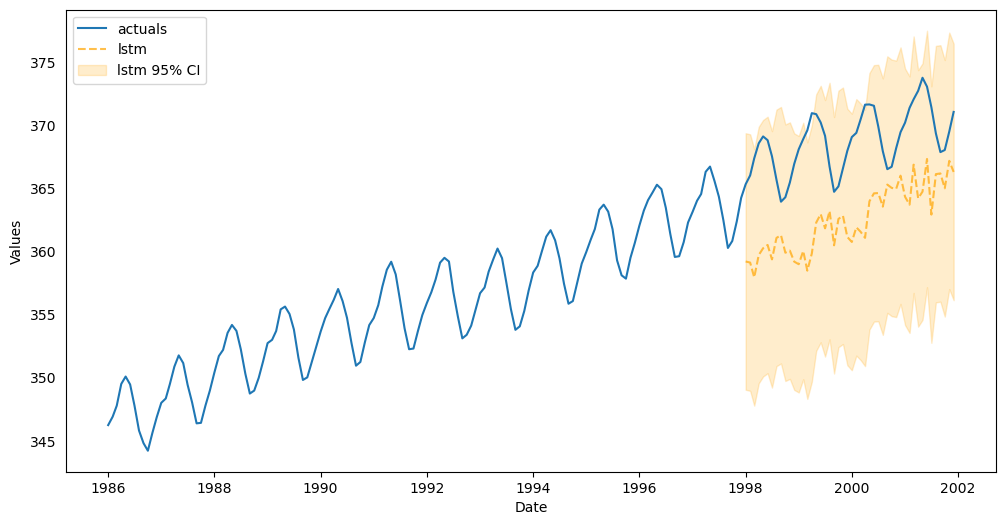

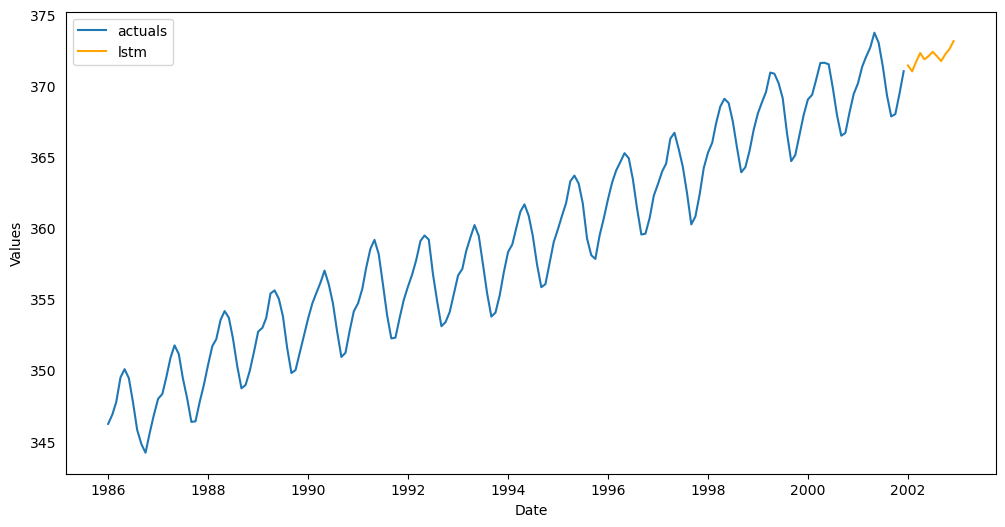

In [37]:
f.plot_test_set(ci=True, models=['lstm'])
f.plot(models=['lstm']);